In [48]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, random_split

In [49]:
df = pd.read_csv("/content/sazerac_df.csv", parse_dates=["date"])
df = df[['date', 'store', 'itemno', 'pack', 'bottle_volume_ml', 'sale_bottles']]
df = (
    df.groupby(['store', 'itemno', 'date'], as_index=False)
      .agg({
          'pack': 'first',
          'bottle_volume_ml': 'first',
          'sale_bottles': 'sum'
      })
)

In [50]:
target_store = df['store'].value_counts().idxmax()
df = df[df['store'] == target_store]

top_item = df['itemno'].value_counts().idxmax()
df = df[df['itemno'] == top_item]

df = df.reset_index(drop=True)

In [51]:
def fill_missing_dates(df):
    filled = []
    for (store, item), group in df.groupby(['store', 'itemno']):
        group = group.sort_values('date').set_index('date')
        full_idx = pd.date_range(group.index.min(), group.index.max())
        group = group.reindex(full_idx)

        group['store'] = store
        group['itemno'] = item
        group['sale_bottles'] = group['sale_bottles'].fillna(0)
        group[['pack', 'bottle_volume_ml']] = group[['pack', 'bottle_volume_ml']].ffill()

        group = group.reset_index().rename(columns={'index': 'date'})
        filled.append(group)

    return pd.concat(filled, ignore_index=True)

df = fill_missing_dates(df)

In [52]:
scalers = {
    'sale_bottles': MinMaxScaler(),
    'pack': MinMaxScaler(),
    'bottle_volume_ml': MinMaxScaler()
}
for col in scalers:
    df[col] = scalers[col].fit_transform(df[[col]])

In [53]:
class LiquorForecastDataset(Dataset):
    def __init__(self, df, seq_len=30, horizon=30):
        self.seq_len = seq_len
        self.horizon = horizon
        self.groups = []

        for (store, item), group in df.groupby(['store', 'itemno']):
            group = group.sort_values('date').reset_index(drop=True)
            data = group[['sale_bottles', 'pack', 'bottle_volume_ml']].values

            for i in range(len(data) - seq_len - horizon):
              y_seq = data[i + seq_len : i + seq_len + horizon, 0]
              if y_seq.sum() > 0:
                  self.groups.append((store, item, data, i))

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        store, item, data, i = self.groups[idx]
        x = data[i : i + self.seq_len]
        y = data[i + self.seq_len : i + self.seq_len + self.horizon, 0]
        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
            store,
            item
        )



In [74]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.W_q = nn.Linear(hidden_dim, hidden_dim)
        self.W_k = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1)

    def forward(self, query, keys):
        q_proj = self.W_q(query)
        k_proj = self.W_k(keys)
        scores = self.v(torch.tanh(q_proj + k_proj)).squeeze(-1)
        weights = torch.softmax(scores, dim=-1)
        context = (weights.unsqueeze(-1) * keys).sum(dim=1)
        return context, weights

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = dim ** 0.5

    def forward(self, query, key, value):
        scores = torch.bmm(query, key.transpose(1, 2)) / self.scale
        weights = torch.softmax(scores, dim=-1)
        context = torch.bmm(weights, value)
        return context, weights

class HybridLSTMAttention(nn.Module):
    def __init__(self, input_dim, seq_len, lstm_units=128, dense_units=100, forecast_horizon=30, attention_type='multihead', num_heads=1):
        super(HybridLSTMAttention, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.lstm_units = lstm_units
        self.attention_type = attention_type

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_units, batch_first=True)

        if attention_type == 'multihead':
            self.attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, batch_first=True)
            self.attn_output_dim = input_dim
        elif attention_type == 'additive':
            self.attn = AdditiveAttention(lstm_units)
            self.attn_output_dim = lstm_units
        elif attention_type == 'scaled_dot':
            self.attn = ScaledDotProductAttention(lstm_units)
            self.attn_output_dim = lstm_units
        else:
            raise ValueError("Unsupported attention type")

        self.flattened_dim = seq_len * (input_dim + lstm_units + self.attn_output_dim)

        self.fcdl = nn.Sequential(
            nn.Linear(self.flattened_dim, dense_units),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(dense_units, forecast_horizon)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        if self.attention_type == 'multihead':
            attn_out, _ = self.attn(x, x, x)
        elif self.attention_type == 'additive':
            context, _ = self.attn(lstm_out, lstm_out)
            attn_out = context.unsqueeze(1).expand(-1, self.seq_len, -1)
        elif self.attention_type == 'scaled_dot':
            context, _ = self.attn(lstm_out, lstm_out, lstm_out)
            attn_out = context
        else:
            raise ValueError("Invalid attention type")

        x_flat = x.reshape(x.size(0), -1)
        lstm_flat = lstm_out.reshape(x.size(0), -1)
        attn_flat = attn_out.reshape(x.size(0), -1)

        concat = torch.cat([x_flat, lstm_flat, attn_flat], dim=1)
        dense_out = self.fcdl(concat)
        return self.output_layer(dense_out)


In [55]:
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for xb, yb, *_ in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb, store_id, item_id in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        print(f"Epoch {epoch}, Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    model.load_state_dict(best_model)
    return model

In [66]:
from torch.utils.data import Subset

dataset = LiquorForecastDataset(df)

total_len = len(dataset)
train_len = int(total_len * 0.8)

train_indices = list(range(train_len))
val_indices = list(range(train_len, total_len))

train_ds = Subset(dataset, train_indices)
val_ds = Subset(dataset, val_indices)

In [76]:
from copy import deepcopy

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

attention_types = ['multihead', 'additive', 'scaled_dot']
trained_models = {}

for attn_type in attention_types:
    print(f"Training model with {attn_type} attention...")
    model = HybridLSTMAttention(input_dim=3, seq_len=30, forecast_horizon=30, attention_type=attn_type)
    model = train_model(model, train_loader, val_loader, epochs=50)
    trained_models[attn_type] = deepcopy(model)

Training model with multihead attention...
Epoch 0, Val Loss: 0.0096
Epoch 1, Val Loss: 0.0084
Epoch 2, Val Loss: 0.0064
Epoch 3, Val Loss: 0.0047
Epoch 4, Val Loss: 0.0037
Epoch 5, Val Loss: 0.0032
Epoch 6, Val Loss: 0.0031
Epoch 7, Val Loss: 0.0031
Epoch 8, Val Loss: 0.0031
Epoch 9, Val Loss: 0.0030
Epoch 10, Val Loss: 0.0030
Epoch 11, Val Loss: 0.0031
Epoch 12, Val Loss: 0.0030
Epoch 13, Val Loss: 0.0030
Epoch 14, Val Loss: 0.0030
Epoch 15, Val Loss: 0.0030
Epoch 16, Val Loss: 0.0030
Epoch 17, Val Loss: 0.0030
Epoch 18, Val Loss: 0.0030
Epoch 19, Val Loss: 0.0029
Epoch 20, Val Loss: 0.0030
Epoch 21, Val Loss: 0.0029
Epoch 22, Val Loss: 0.0029
Epoch 23, Val Loss: 0.0029
Epoch 24, Val Loss: 0.0029
Epoch 25, Val Loss: 0.0029
Epoch 26, Val Loss: 0.0029
Epoch 27, Val Loss: 0.0029
Epoch 28, Val Loss: 0.0029
Epoch 29, Val Loss: 0.0029
Epoch 30, Val Loss: 0.0029
Epoch 31, Val Loss: 0.0029
Epoch 32, Val Loss: 0.0029
Epoch 33, Val Loss: 0.0029
Epoch 34, Val Loss: 0.0029
Epoch 35, Val Loss: 0.

In [77]:
def evaluate_and_plot_multiple(models, data_loader, scaler, device='cuda' if torch.cuda.is_available() else 'cpu'):
    plt.figure(figsize=(12, 6))

    for attn_type, model in models.items():
        model.eval()
        model.to(device)
        predictions, actuals = [], []

        with torch.no_grad():
            for xb, yb, *_ in data_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                predictions.append(pred.cpu().numpy())
                actuals.append(yb.cpu().numpy())

        predictions = np.concatenate(predictions, axis=0)
        actuals = np.concatenate(actuals, axis=0)

        predictions_denorm = scaler.inverse_transform(predictions)
        actuals_denorm = scaler.inverse_transform(actuals)

        idx = np.random.randint(0, len(predictions))
        plt.plot(predictions_denorm[idx], label=f"{attn_type} pred")

    plt.plot(actuals_denorm[idx], label="Actual", linewidth=2, color='black')
    plt.title("Forecast Comparison: Attention Variants")
    plt.xlabel("Days Ahead")
    plt.ylabel("Bottles Sold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

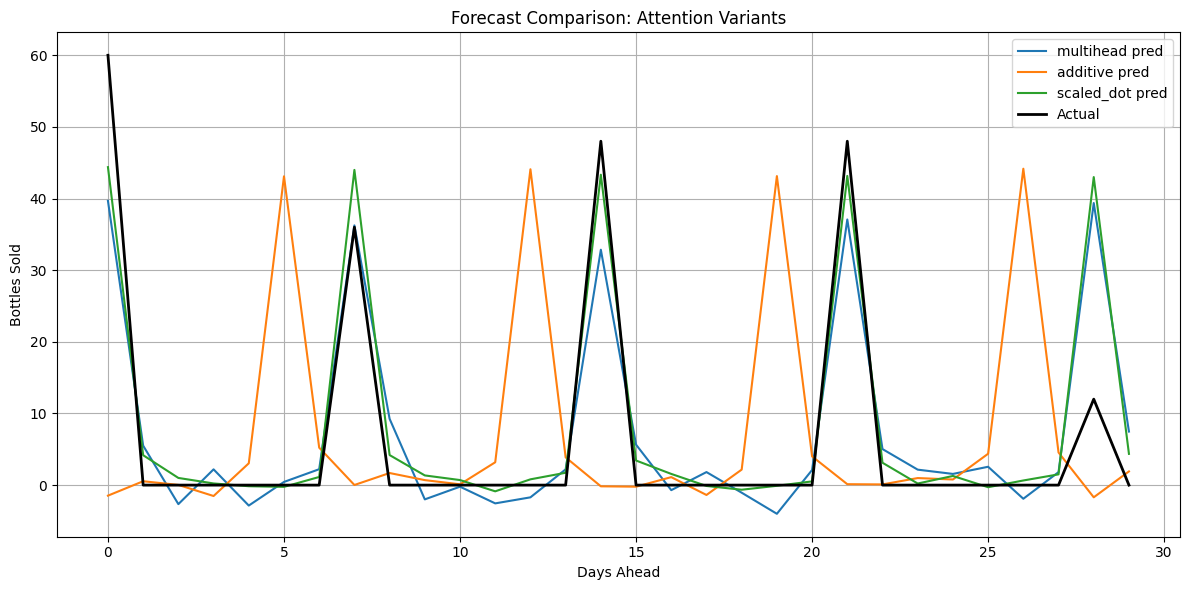

In [81]:
evaluate_and_plot_multiple(trained_models, val_loader, scalers['sale_bottles'])